## Setup for Colab

In [ ]:
!pip install shap

**NOTE:** If the SHAP visualizations don't load with the message `"Visualization omitted, Javascript library not loaded!"`, then try adding the line `shap.initjs()` to the code cell.

## Model Creation

In [1]:
from collections import OrderedDict

import numpy as np
import pandas as pd
import xgboost
import shap

shap.initjs()

In [2]:
x, y = shap.datasets.boston()

Scikit documentation contains information on the [Boston dataset](https://scikit-learn.org/stable/datasets/index.html#boston-dataset).

In [3]:
x.shape

(506, 13)

In [4]:
x.head(3)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03


In [5]:
y[:3]

array([24. , 21.6, 34.7])

In [6]:
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(x, label=y), 100)

## Feature Importance

In [7]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x)

In [8]:
shap_values.shape

(506, 13)

In [9]:
explainer.expected_value

14.230186

### shap.force_plot

Prediction: 7.95


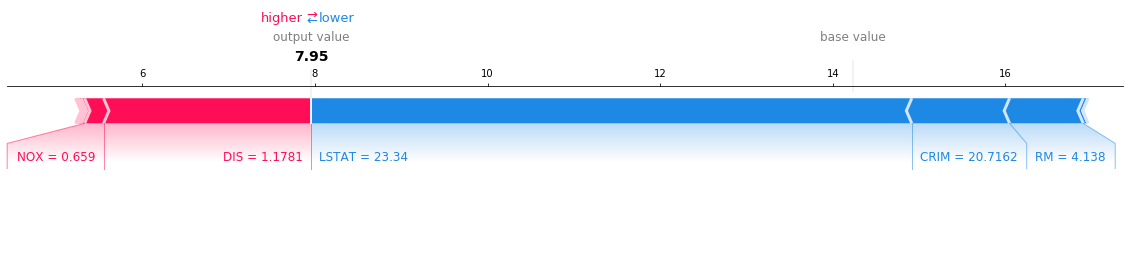

In [10]:
## first in sample order by similarity: 406 (7.95)
## first in sample order by output value: 161 (28.98)
## first in original sampling order: 0 (16.49)
## order by ZN: 41
idx =  406

print(f"Prediction:{model.predict(xgboost.DMatrix(x.iloc[[idx], :]))[0]: .2f}")
shap.force_plot(explainer.expected_value, shap_values[idx,:], x.iloc[idx,:], matplotlib=True)

The above explanation shows features contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

In [11]:
shap_df = pd.DataFrame(OrderedDict({
    "feature": x.columns,
    "feature value": x.iloc[idx, :].values,
    "shap value": shap_values[idx, :],
}))

descending_shaps = shap_df["shap value"].abs().sort_values(ascending=False).index
shap_df.iloc[descending_shaps].reset_index(drop=True)

,feature,feature value,shap value
0,LSTAT,23.3400,-6.962972
1,DIS,1.1781,2.403132
2,CRIM,20.7162,-1.133251
3,RM,4.1380,-0.853733
4,NOX,0.6590,0.219596
5,TAX,666.0000,-0.054520
6,AGE,100.0000,0.038467
7,PTRATIO,20.2000,0.030281
8,INDUS,18.1000,0.019334
9,B,370.2200,0.011321


If we take many explanations such as the one shown above, rotate them 90 degrees, and then stack them horizontally, we can see explanations for an entire dataset.

In [12]:
shap.force_plot(explainer.expected_value, shap_values, x)

Info on how "similarity" is calculated for the stacked plot: https://github.com/slundberg/shap/issues/61#issuecomment-383160894

<div class="alert alert-danger">
WARNING: The stacked area plot seems to have a few bugs.
</div>

### shap.summary_plot

To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample. The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output. The color represents the feature value (red high, blue low).

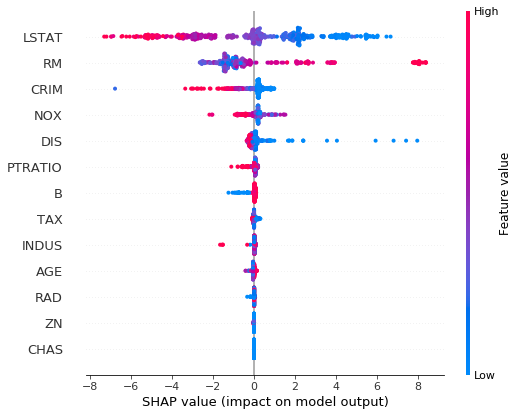

In [13]:
shap.summary_plot(shap_values, x)

We can just take the mean absolute value of the SHAP values for each feature to get a standard bar plot (produces stacked bars for multi-class outputs):

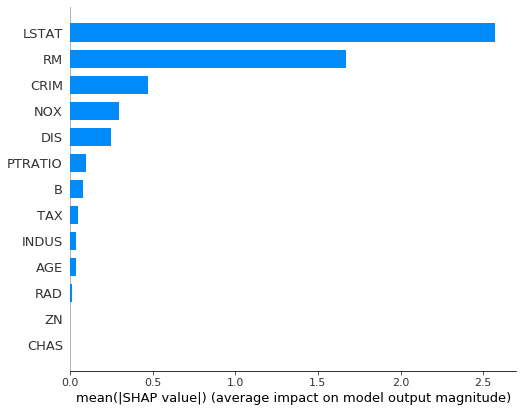

In [14]:
shap.summary_plot(shap_values, x, plot_type="bar")

### shap.dependence_plot

To understand how a single feature effects the output of the model we can plot the SHAP value of that feature vs. the value of the feature for all the examples in a dataset. Since SHAP values represent a feature's responsibility for a change in the model output, the plot below represents the change in predicted house price as LSTAT changes. Vertical dispersion at a single value represents interaction effects with other features. To help reveal these interactions dependence_plot automatically selects another feature for coloring.

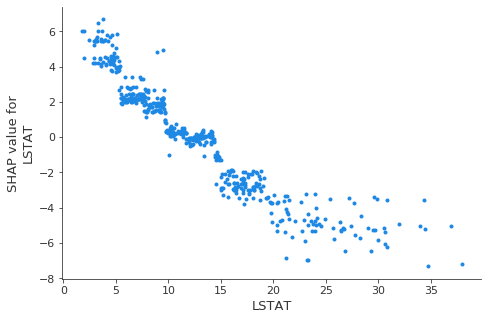

In [15]:
shap.dependence_plot("LSTAT", shap_values, x, interaction_index=None)

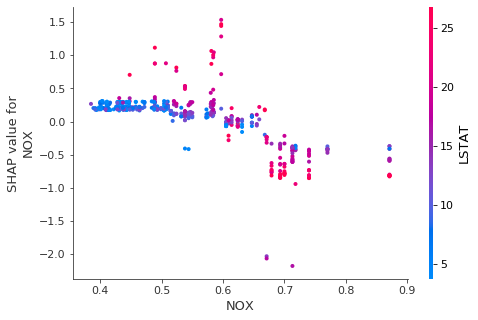

In [16]:
shap.dependence_plot("NOX", shap_values, x, interaction_index="LSTAT")

## Feature Interaction

SHAP interaction values are a generalization of SHAP values to higher order interactions. `shap_interaction_values` return a matrix for every prediction, where the main effects are on the diagonal and the interaction effects are off-diagonal. These values often reveal interesting hidden relationships.

In [17]:
shap_interaction = explainer.shap_interaction_values(x)
shap_interaction.shape

(506, 13, 13)

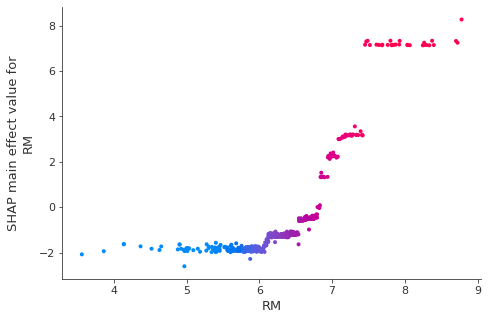

In [18]:
shap.dependence_plot(("RM", "RM"), shap_interaction, x)

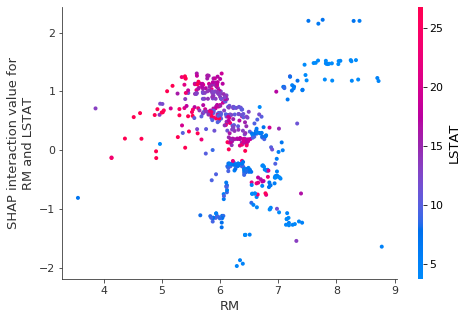

In [19]:
shap.dependence_plot(("RM", "LSTAT"), shap_interaction, x)

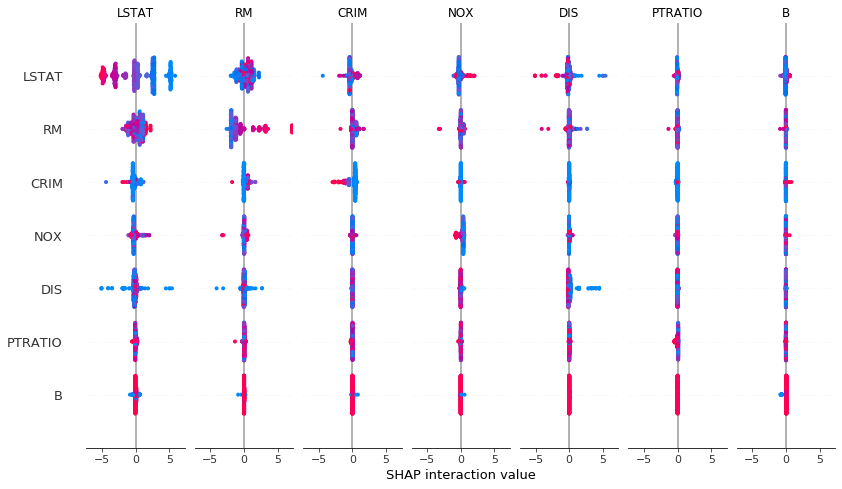

In [20]:
shap.summary_plot(shap_interaction, x)